In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def load_data(path, is_mountain_car=False):
    if not os.path.exists(path):
        return np.array([]), np.array([]), np.array([])
    data = np.genfromtxt(path, delimiter=',', skip_header=1, usecols=(3 if is_mountain_car else 2))
    data_100avg = np.empty(data.shape[0])
    data_avg = np.empty(data.shape[0])
    for i in range(data.shape[0]):
        data_100avg[i] = np.mean(data[max(0, i - 100):(i + 1)])
        data_avg[i] = np.mean(data[0:(i + 1)])
    return data, data_100avg, data_avg

def plot_single_data(title, data, data_100avg, data_avg, is_mountain_car=False, x_lim=1000):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data, 'c')
    ax.plot(data_100avg, 'r')
    ax.plot(data_avg, 'k')
    ax.plot(np.full((x_lim), -110 if is_mountain_car else 200), 'k:')
        
    ax.legend(["Running reward", "Avg 100", "Running avg"])
    
    plt.title(title, size=16)
    plt.xlabel('episode', size=14)
    plt.ylabel('reward', size=14)
    plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
    plt.xlim([0, x_lim])
    plt.show()
    
def plot_all(at_path, x_lim=1000, is_mountain_car=False):
    splitted_path = at_path.split("/")
    title = splitted_path[1]
    colors = ["r", "g", "b", "y", "k"]
    fig, ax = plt.subplots(figsize=(8, 6))
    for run in range(5):
        sub_path = f'{at_path}/{run}/logs/data.csv'
        data, avg_100, avg = load_data(sub_path)
        ax.plot(avg_100, f'{colors[run]}')
    ax.plot(np.full((x_lim), -110 if is_mountain_car else 200), 'k:')
    plt.title(title, size=16)
    plt.xlabel('episode', size=14)
    plt.ylabel('average reward', size=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.xlim([0, x_lim])
    plt.show()
    
def plot_row(path_list, title_list,x_lim=1000, is_mountain_car=False, xlim = 0):
    #splitted_path = path_list[0].split("/")
    #title = splitted_path[1]
    
    colors = ["r", "g", "b", "y", "k"]
    fig, ax = plt.subplots(1, len(path_list), figsize=(20, 6)) 
    
    #plt.title(title, size=16)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    
    for i, sp_i in enumerate(path_list):
        
        data_max = 0
        for run in range(5):
            sub_path = f'{sp_i}/{run}/logs/data.csv'
            data, avg_100, avg = load_data(sub_path)
            if data.shape[0] > data_max:
                data_max = data.shape[0]
            ax[i].plot(avg_100, f'{colors[run]}')
            ax[i].set_title(title_list[i], size=16)
            ax[i].set_xlabel('episode', size=14)
            
            ax[i].set_ylabel('average reward', size=14)
            ax[i].label_outer()
            if xlim != 0:
                ax[i].set_xlim([0,xlim])
        ax[i].plot(np.full(max(xlim, data_max), -110 if is_mountain_car else 200), 'k:')
    plt.show()

# Projekt 13

- 1 **DQN** 
    - 1.1 Theorie
    - 1.2 Implementierung
    - 1.3 Tensorflow
    - 1.4 Evaluation
        - 1.4.1 MountainCar
        - 1.4.2 LunarLander
- 2 **Dueling Architektur**
    - 2.1 Theorie
    - 2.2 Implementierung
- 3 **Prioritized Experience Replay**
    - 3.1 Theorie
    - 3.2 Implementierung
- 4 **Vergleich der Ansätze**
    - 4.1 Einfluss einzelner Parameter
    - 4.2 Vergleich der Architekturen
    - 4.3 Verbesserte Architektur für Mountaincar

# 1 DQN

## 1.1 Theorie

Ansatz DQN nach Watkins:
 - Trainiere um $Q$ Werte (erwarteter zukünftiger reward) für gegebenes State Action Paar abzuschätzen
 - geschieht durch optimieren der Kosten Funktion:
$L_i(\theta_i) = E_{(s,a) \sim{~} P(s,a)} \left[ Q^*(s,a) - Q(s,a; \theta_i ) \right]^2$
 - wobei target $Q^*(s,a)$ Werte gegeben sind als:
$Q^*(s,a) = E_{s' \in S} \left[ R(s,a) + \gamma \max_{a'} Q(s', a'; \theta_{i-1} ) \middle| s, a \right]$
 - mit $R(s,a)$ immediate reward für $(s,a)$ und $Q(s', a'; \theta_{i-1} )$ Q Wert approximiert vom Netz mit State t+1 und vorherigen weights

## 1.2 Implementierung

Basierend auf dem Paper "Balancing a CartPole System with Reinforcement Learning - A Tutorial"

DQN-Algorithmus
```python
def run(self, solved_threshold, max_episodes=1000):
   
    for e in range(max_episodes):

        state = self.env.reset().reshape(1, self.state_size)
        done = False

        while not done:

            # policy
            a = agent.select_action(state)
            
            next_state, reward, done, info = self.env.step(a)
            next_state = np.reshape(next_state, [1, self.state_size])

            # use replay memory
            agent.add_experience(state, a, reward, next_state, done)

            # experience replay - training
            agent.train_model()

            steps += 1
            state = next_state
            total_reward += reward

            if steps % target_network_update_freq == 0 or done:
                agent.update_target_network()

            if done: break

        if avg_last_100 >= solved_threshold:
            print('The problem is solved in {} episodes. Exiting'.format(e))
            break

```

Erstellen des Netzes
```python
def _build_model(self):
    # Advantage network
    network_input = Input(shape=(self.state_size,), name='network_input')
    A1 = Dense(24, activation='relu', name='A1')(network_input)
    A2 = Dense(24, activation='relu', name='A2')(A1)
    A3 = Dense(self.action_size, activation='linear', name='A3')(A2)
    network_output = A3

    model = Model(network_input, network_output)
    model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
    model.summary()
    return model
```

Berechnung des target Q-values anhand des target Netzwerks als $ \max_{a'}  Q( s', a'; \theta_{i-1} )$.

```python
def get_maxQvalue_nextstate(self, next_state):
    return np.amax(self.target_model.predict(next_state)[0])

def get_maxQvalue_nextstate_batch(self, next_states):
    qValues_next_state = self.target_model.predict(next_states)
    max_q_values = np.max(qValues_next_state, axis=1)
    return max_q_values
```

$ \epsilon $-Greedy Policy für die Wahl der Actions
```python 
def select_action(self, state):
    if (random.random() < self.epsilon):
        return np.random.randint(0, self.action_size)
    else:
        q_values = self.model.predict(state)
        action = np.argmax(q_values[0])
        return action
```

Verwendung von Experience Buffer $B=(e_1, ..., e_K)$ zum Speichern der letzen K Entscheidungen $e_t = (s_t, a_t, r_t, s_{t+1})$

```python
self.memory = deque(maxlen=self.memory_size)
```


```python
def add_experience(self, state, action, reward, next_state, done):
    self.memory.append([state, action, reward, next_state, done])
```

Zur Stabilisierung des Konvergenzverhaltes, wird ein Model zum Trainieren und eines zum predicten (target models) erstellt. Dadurch werden Trainingseffekte während einer Episode verhindert.
Update des target models nach B Trainingsschritten.

```python
self.model = self._build_model()
self.target_model = self._build_model()
```

```python
def update_target_network(self):
    self.target_model.set_weights(self.model.get_weights())
```

Training des Models auf Mini-Batch mittels ziehen aus Replay-Buffer
```python    

def train_model(self):

    if len(self.memory) < self.train_start:
        return (0, 0)

    mini_batch = random.sample(self.memory, self.batch_size)
    
    ...

    for i in range(self.batch_size):
        current_state[i] = mini_batch[i][0] 
        action[i] = mini_batch[i][1]
        reward[i] = mini_batch[i][2]
        next_state[i] = mini_batch[i][3]
        done[i] = mini_batch[i][4]

    q_values = self.model.predict(current_state)
    max_q_values_ns = self.get_maxQvalue_nextstate_batch(next_state)

    for i in range(self.batch_size):
        if done[i]:
            q_values[i][action[i]] = reward[i]
        else:
            q_values[i][action[i]] = reward[i] + self.discount_factor * max_q_values_ns[i]

    # train the model
    self.model.fit(current_state, q_values,
                   batch_size=self.batch_size,
                   epochs=1, verbose=0)

    # update epsilon with each training step
    if self.epsilon > 0.01:
        self.epsilon *= self.epsilon_decay_rate
    else:
        self.epsilon = 0.01
```

## 1.3 Tensorflow

- Beschleunigte Trainingsmethode in Tensorflow
- Keras Model $\rightarrow$ Tensorflow.Keras Model
- numpy Arrays und Konstanten $\rightarrow$ Tensorflow Variablen
- Manuelle Berechnung des Gradienten
```python
@tf.function
def train_fast(self, states, actions, rewards, next_states, dones):
    
    states = tf.squeeze(states)
    next_states = tf.squeeze(next_states)

    with tf.GradientTape() as g:
        
        # Compute max a' Q(s',a',theta_target)  
        max_qvalues_ns = tf.math.reduce_max(self.target_model(next_states), axis=1)
        # Compute Q*(s,a) = R(s,a) + gamma * max a' Q(s',a',theta_target)   
        targets = rewards + tf.constant(self.discount_factor) * max_qvalues_ns * (1 - dones)
        
        indices = tf.range(tf.constant(self.batch_size), dtype=np.int32)
        # Compute Q(s,a)
        q_values = tf.gather_nd(self.model(states), tf.stack((indices, actions), -1))
        # Compute Loss: [ Q*(s,a) - Q(s,a) ]^2
        loss = tf.keras.losses.mse(targets, q_values)

    # Compute the gradients from the loss
    grads = g.gradient(loss, self.model.trainable_variables)
    
    # Apply the gradients to the model's parameters
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
    ...
```

## 1.4 Evaluation

Standardarchitektur:
- Netzwerkarchitektur: 8_24_24_4 (LunarLander), 2_24_24_3 (MountainCar)
- Batch Size: 24
- Memory Length: 2000
- Learning rate: 0.001
- Epsilon Decay Rate: 0.996
- Train Start: 1000

Environments:

**MountainCar-v0**:

    State:
        Dimension    Observation
        1            Position
        2            Geschwindigkeit
    Actions:
        Dimension    Action
        1            Beschleunige nach links
        2            keine Beschleunigung
        3            Beschleunige nach rechts
        
**LunarLander-v2**: 

    State:
        Dimension    Observation
        1            Position x
        2            Position y
        3            Geschwindigkeit x
        4            Geschwindigkeit y
        5            Winkel 
        6            Winkelgeschwindigkeit 
        7            Bodenkontakt linkes Bein 
        8            Bodenkontakt rechts Bein 
        
        
    Actions:
        Dimension    Action
        1            keine Aktion
        2            feuere linke Engine 
        3            feuere main Engine
        4            feuere rechte Engine

## 1.4.1 **MountainCar-v0**

### Standard Architektur

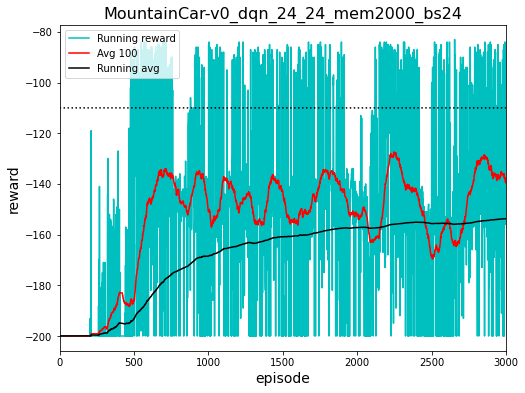

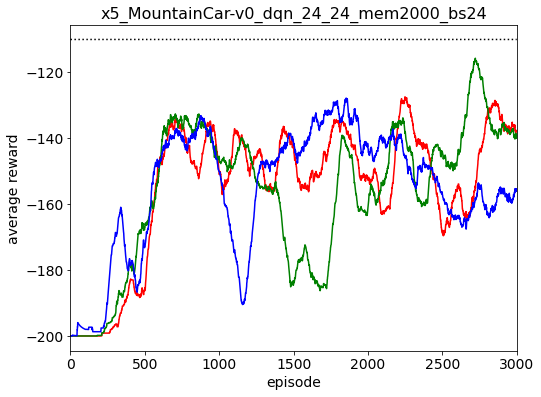

In [3]:
eps, eps_avg_100, eps_avg = load_data(path="results/x5_MountainCar-v0_dqn_24_24_mem2000_bs24/0/logs/data.csv")
x, x_avg_100, _ = load_data(path="results/x5_MountainCar-v0_dqn_24_24_mem2000_bs24/0/logs/data.csv", is_mountain_car=True)
plot_single_data("MountainCar-v0_dqn_24_24_mem2000_bs24", eps, eps_avg_100, eps_avg, is_mountain_car=True, x_lim=3000)
#plot_single_data("MountainCar-v0_dqn_24_24_mem2000_bs24", np.array([]), x_avg_100, np.array([]))
plot_all(at_path='results/x5_MountainCar-v0_dqn_24_24_mem2000_bs24', x_lim=3000, is_mountain_car=True)

### Anpassungen

- Netzwerkarchitektur: 2_24_48_3
- Batch Size: 32
- Memory Length: 20000
- Learning rate: 0.001
- Epsilon Decay Rate: 0.996
- Train Start: 1000

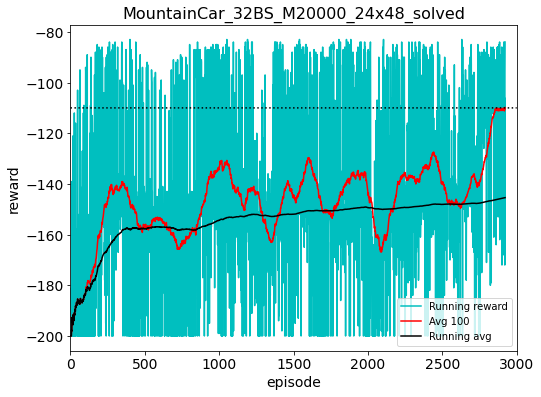

In [4]:
data, avg_100, avg = load_data(path="results/MC_var_DQN/0/logs/data.csv")
plot_single_data("MountainCar_32BS_M20000_24x48_solved", data, avg_100, avg, is_mountain_car=True, x_lim=3000)

|  0 Episoden  |  150 Episoden  |  200 Episoden  |  666 Episoden  |
|---|---|---|---|
|  ![1. Variante](results/gifs/MC0.gif)  |  ![1. Variante](results/gifs/MC150.gif)  |  ![1. Variante](results/gifs/MC200.gif)  |  ![1. Variante](results/gifs/MC666.gif)  |

## 1.4.2 **LunarLander-v2**

### Standardarchitektur

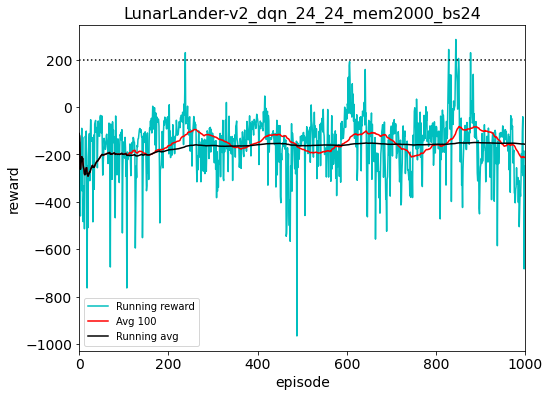

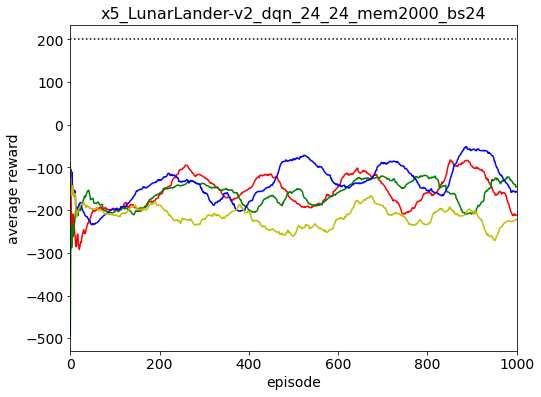

In [5]:
data, avg_100, avg = load_data(path="results/x5_LunarLander-v2_dqn_24_24_mem2000_bs24/0/logs/data.csv")
plot_single_data("LunarLander-v2_dqn_24_24_mem2000_bs24",data, avg_100, avg)
plot_all(at_path='results/x5_LunarLander-v2_dqn_24_24_mem2000_bs24')

### Anpassungen

- Netzwerkarchitektur: 8_150_120_4
- Batch Size: 64
- Memory Length: 1000000
- Learning rate: 0.001
- Epsilon Decay Rate: 0.996
- Train Start: 1000

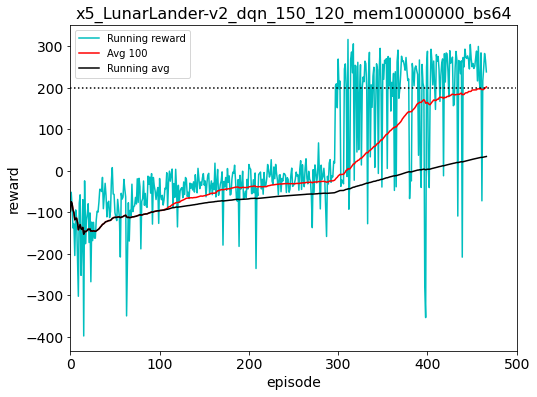

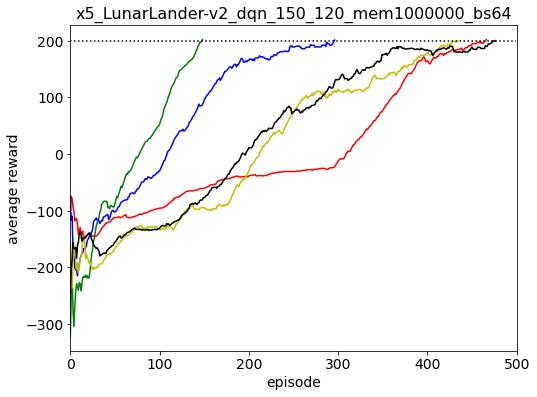

In [6]:
data, avg_100, avg = load_data(path="results/x5_LunarLander-v2_dqn_150_120_mem1000000_bs64/0/logs/data.csv")
plot_single_data("x5_LunarLander-v2_dqn_150_120_mem1000000_bs64", data, avg_100, avg, x_lim=500)
plot_all(at_path='results/x5_LunarLander-v2_dqn_150_120_mem1000000_bs64',x_lim=500)

|  0 Episoden  |  50 Episoden  |
|---|---|
| ![1. Variante](results/gifs/LL0.gif) | ![1. Variante](results/gifs/LL50.gif)  |

|  100 Episoden  |  142 Episoden  |
|---|---|
| ![1. Variante](results/gifs/LL100.gif) | ![1. Variante](results/gifs/LL142.gif) |

## 2 Dueling DQN
## 2.1 Theorie

- Aufteilung von $Q$-value in Summe aus $V(s)$ und $A(s,a)$
    - mit $V(s) = \max_a Q(s,a)$ unabhängig von einer action die Güte des States angibt und eine baseline darstellt 
    - $A(s,a) = Q(s,a) - E_{a \sim{~} \pi } [ Q(s,a) ]$ den advantage mit state $s$ action $a$ auszuführen
    
- Vorteile:  
    - Varianz von $Q$ minimieren, durch abziehen des Erwartungswertes (**robuster**)
    - Wert eines States zu lernen, ohne Effekt Effekt jeder Action an jedem State lernen zu müssen (**zeiteffizienter**)
    
**Problem:** bei einfacher Addition von $V(s)$ und $A(s,a)$ sind diese Terme nicht einfach unter gegebenem $Q(s,a)$ bestimmbar $\Rightarrow$ Konvergenz schwierig

**Lösung:** 

Dueling DQN with max:

$Q(s,a) = V(s, \beta) + A(s,a, \alpha) - \max_{a'} A(s,a',\alpha)$

Dueling DQN with avg:

$Q(s,a) = V(s, \beta) + A(s,a, \alpha) -  \frac{1}{\lvert A \rvert}  \sum_{a'} A(s,a',\alpha)$

## 2.2 Implementierung

| Variante 1 | Variante 2 |
|---|---|
| ![1. Variante](results/images/Duel_DQN_2_medium.png) | ![2. Variante](results/images/Duel_DQN_2Stream_medium.png) |

```python
def _build_model(self):
    # Advantage network
    network_input = Input(shape=(self.state_size,), name='network_input')

    A1 = Dense(150, activation='relu', name='A1', kernel_initializer=initializer)(network_input)
    A2 = Dense(120, activation='relu', name='A2', kernel_initializer=initializer)(network_input)
    A3 = Dense(self.action_size, activation='linear', name='A3')(A2)
    
    V3 = Dense(1, activation='linear', name='V3')(prev_adv_layer)

    if self.dueling_option == 'avg':
        network_output = Lambda(lambda x: x[0] - tf.reduce_mean(x[0]) + x[1], output_shape=(self.action_size,),
                                name='network_output')([A3, V3])
    elif self.dueling_option == 'max':
        network_output = Lambda(lambda x: x[0] - tf.reduce_mean(x[0]) + x[1], output_shape=(self.action_size,),
                                name='network_output')([A3, V3])
    elif self.dueling_option == 'naive':
        network_output = Lambda(lambda x: x[0] + x[1], output_shape=(self.action_size,), name='network_output')(
            [A3, V3])
    else:
        raise Exception('Invalid Dueling Option')

    model = Model(network_input, network_output)
    model.summary()
                    
    return model
```

## 3 Prioritized Experience Replay
## 3.1 Theorie

* An Stelle von uniformen Ziehen aus Replay-Buffer, Priorisierung mit TD-Error
$$ \delta_t= y_t - Q(s,a, w) \stackrel{with \; DQN}{=} r(s) + \gamma \max_a Q(s_{t+1},a, w) - Q(s,a, w)$$
* mit sample Wahrscheinlichkeit $P(i) = \frac{ p_i^\alpha }{\sum_{k} p_k^\alpha}$, wobei $p_i =  \lvert \delta_i \rvert  + \epsilon$
* Wahl von $\alpha$ beeinflusst Stärke der Priorisierung und Abweichung von uniformer Verteilung
* seltene Ereignisse mit hoher Wichtigkeit (starken Lerneffekt erziehlen) werden stärker gewichtet

## 3.2 Implementierung

- Zur Optimierung der Laufzeit wird ein Binärbaum verwendet
    - Blätter enthalten die Prioritäten und Daten der Einträge
    - Gewichte der Äste werden zum Suchen der Einträge benutzt
    - Führt zu Laufzeit $\mathcal{O} \left( log(n) \right)$ zum ziehen und updaten der Gewichte
 

```python
@tf.function
def train_fast(...):
    
    ...

    if self.per:
        absolute_errors = tf.math.abs(q_values - targets)
        return absolute_errors
```

```python 
def train_model(self):

    ...

    if self.per:
        tree_idx, mini_batch = self.memory.sample(self.batch_size)
    else:
        if len(self.memory) < self.train_start: return 0
        mini_batch = random.sample(self.memory, self.batch_size)
    ...

    abs_errors = self.train_fast(states, actions, rewards, next_states, dones)

    if self.per:
        self.memory.batch_update(tree_idx, abs_errors)

    ...
```

## 4 Vergleich der Ansätze
## 4.1 Einfluss einzelner Parameter

Als Referenz wurde folgende beste Architektur gewählt:

Dueling DQN auf LunarLander mit
- Netzwerkarchitektur: 8_150_120_4
- Batch Size: 64
- Memory Length: 1000000
- Learning rate: 0.001
- Epsilon Decay Rate: 0.996
- Train Start: 1000

und Mountaincar:
- Netzwerkarchitektur: 2_24_48_3
- Batch Size: 32
- Memory Length: 20000
- Learning rate: 0.001
- Epsilon Decay Rate: 0.996
- Train Start: 1000


## 4.1.1 Einfluss der Batchsize

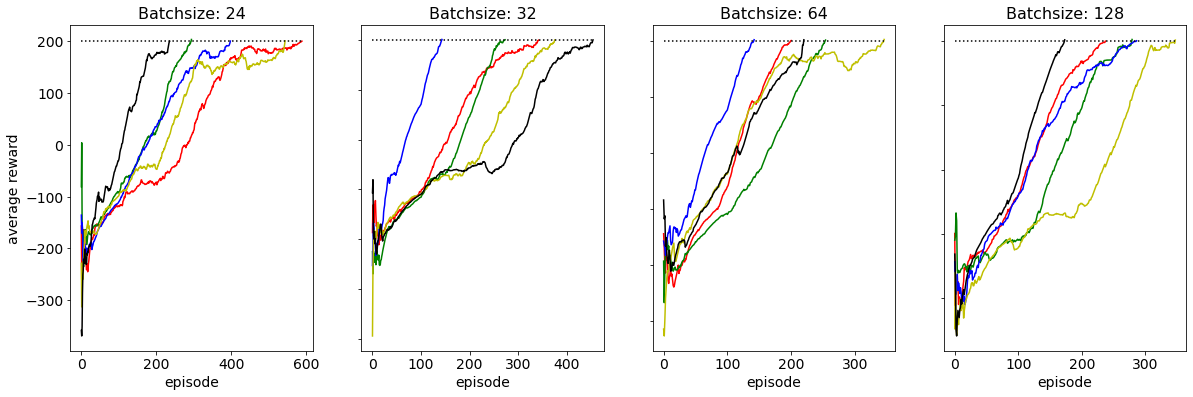

In [7]:
path_list = ['results/Dueling_var_BS_24',
'results/Dueling_var_BS_32',
'results/x5_LunarLander-v2_dueling_dqn_150_120_mem1000000_bs64',
'results/Dueling_var_BS_128']
plot_row(path_list, ['Batchsize: 24', 'Batchsize: 32', 'Batchsize: 64', 'Batchsize: 128'], x_lim=600)

## 4.1.2 Einfluss der Memorysize

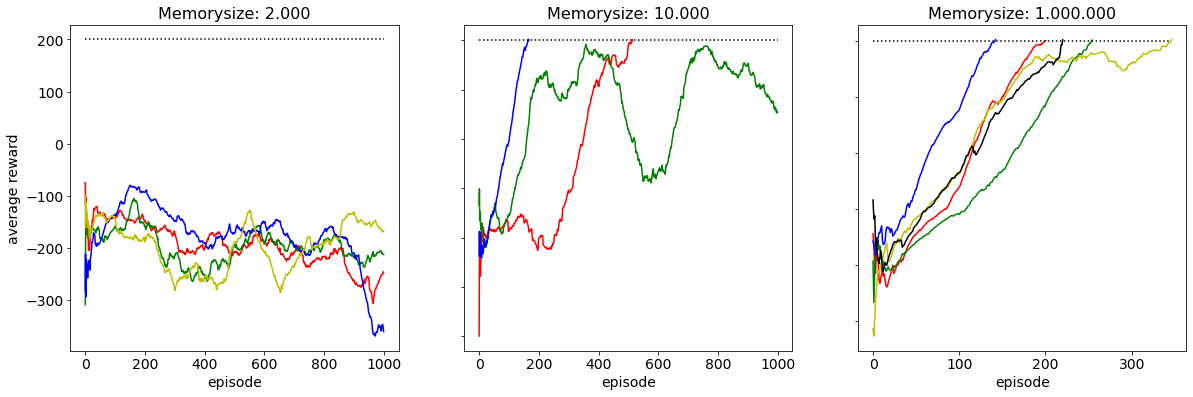

In [8]:
path_list = ['results/Dueling_var_mem2000',
'results/Dueling_var_mem10000',
'results/x5_LunarLander-v2_dueling_dqn_150_120_mem1000000_bs64']
plot_row(path_list, ['Memorysize: 2.000', 'Memorysize: 10.000', 'Memorysize: 1.000.000'])

## 4.1.3 Einfluss verschiedener Layer 

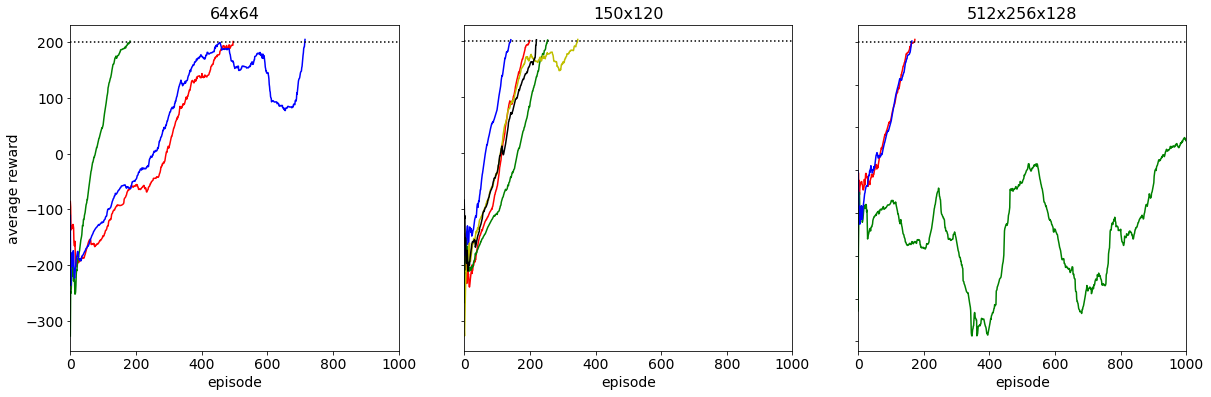

In [9]:
path_list = ['results/LL_var_NN_64_64','results/x5_LunarLander-v2_dueling_dqn_150_120_mem1000000_bs64', 'results/LL_var_NN_512_256_128']
plot_row(path_list, ['64x64', '150x120', '512x256x128'], xlim=1000)

## 4.2 Vergleich der Architekturen

## 4.2.1 LunarLander

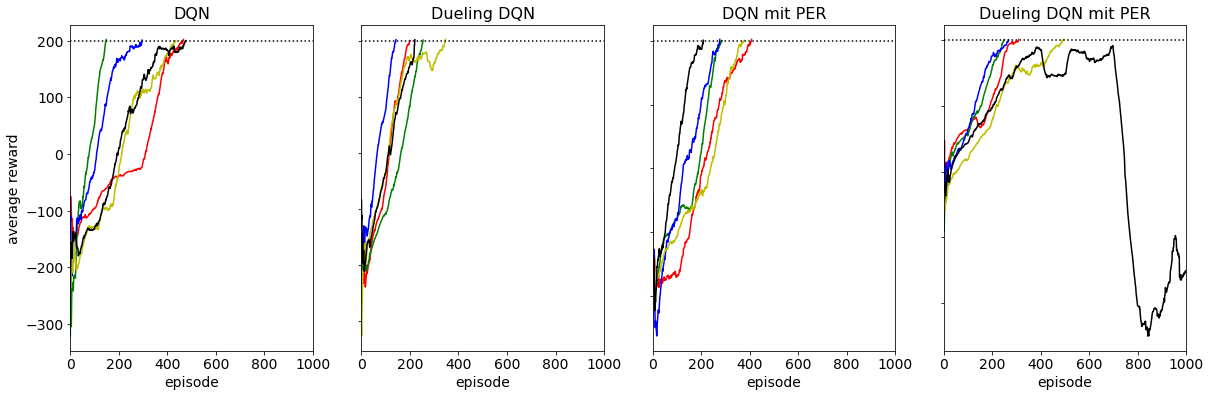

In [10]:
path_list = ['results/x5_LunarLander-v2_dqn_150_120_mem1000000_bs64',
'results/x5_LunarLander-v2_dueling_dqn_150_120_mem1000000_bs64',
'results/x5_LunarLander-v2_dqn_per_150_120_mem1000000_bs64',
'results/x5_LunarLander-v2_dueling_dqn_per_150_120_mem1000000_bs64']
plot_row(path_list, ['DQN', 'Dueling DQN', 'DQN mit PER', 'Dueling DQN mit PER'], xlim=1000)

## 4.2.2 MountainCar

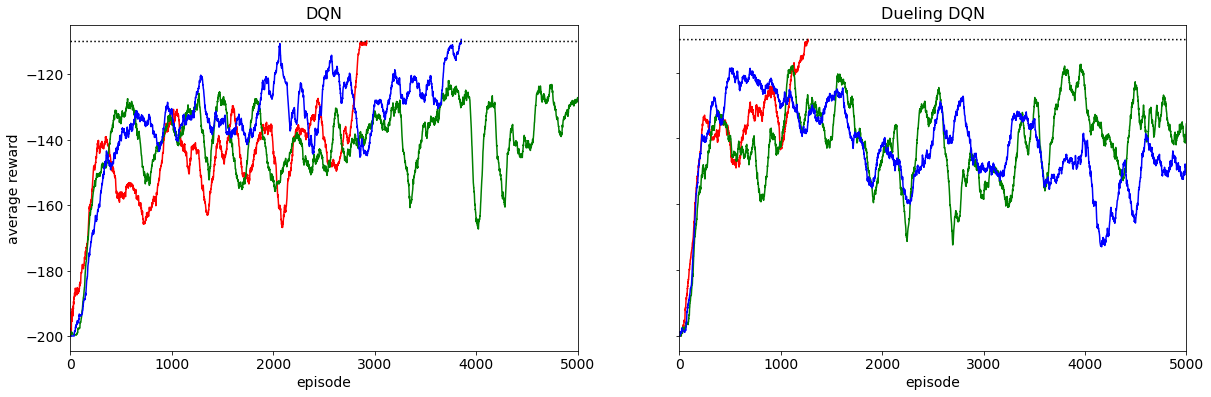

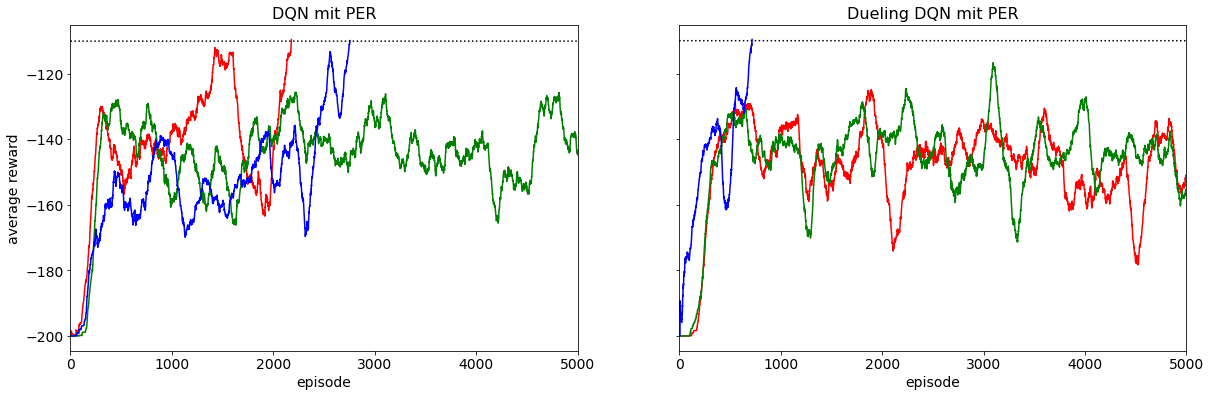

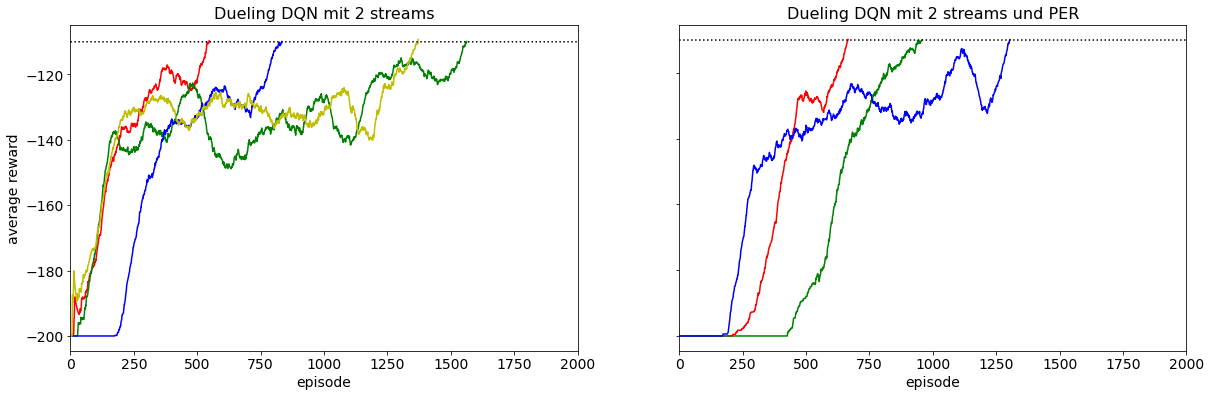

In [11]:
path_list_fist = ['results/MC_var_DQN',
                  'results/MC_var_Dueling_DQN']
path_list_second = ['results/MC_var_PER_DQN', 
             'results/MC_var_Dueling_PER_DQN']
path_list_2streams = ['results/MC_var_Dueling_2stream_DQN', 
                      'results/MC_var_Dueling_2stream_PER_DQN']
plot_row(path_list_fist, ['DQN', 'Dueling DQN'],is_mountain_car = True, xlim=5000)
plot_row(path_list_second, ['DQN mit PER', "Dueling DQN mit PER"],is_mountain_car = True, xlim=5000)
plot_row(path_list_2streams, ['Dueling DQN mit 2 streams', 'Dueling DQN mit 2 streams und PER'],is_mountain_car = True, xlim=2000)
#'Dueling DQN', 'Duiling DQN with PER'x
#'Dueling 2 stream DQN'x, 'Dueling 2 stream DQN with PER'
 

## 4.3 Verbesserte Architektur für Mountaincar

![Variante](results/images/2Stream_DQN_medium.png)

Berechnung von $Q(s,a)$ durch Verwendung von zwei separaten Netzen die folgendermaßen zusammengeführt werden: 
$$Q(s,a) = V(s, a, \beta) + A(s,a, \alpha) -  \frac{1}{\lvert A(s,a',\alpha) \rvert}  \sum_{a'} A(s,a',\alpha)$$

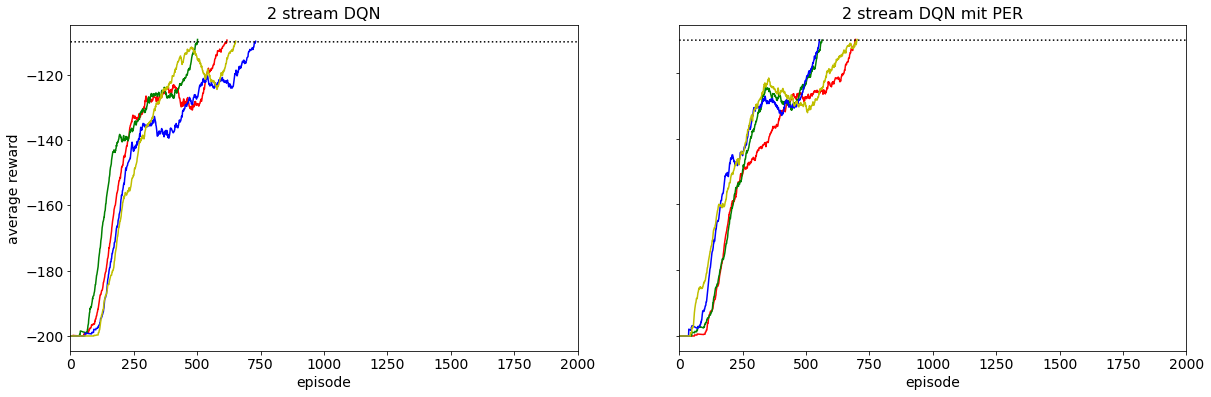

In [12]:
path_list_duel = ['results/MC_var_2stream_DQN', 'results/MC_var_2stream_PER_DQN']
plot_row(path_list_duel, ['2 stream DQN', '2 stream DQN mit PER'],is_mountain_car = True, xlim=2000)